In [54]:
import networkx as nx
import osmnx as ox
from geopy.geocoders import Nominatim

import numpy as np

from initialization import init_sol_greedy_scores
from local_search import loc_search_add, loc_search_exch
from general import total_distance, total_score
from VND import b_vnd

**City to visit**

City to visit: Santander, Spain


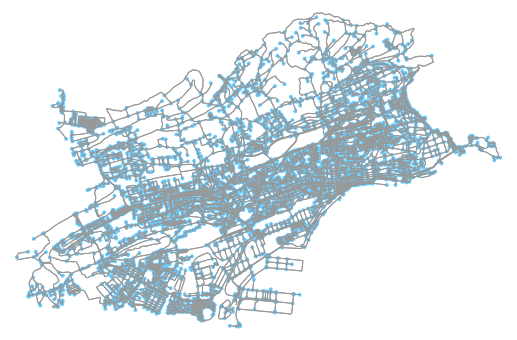

In [29]:
# get a graph for some city
city = input("City to visit: ")
G = ox.graph_from_place(city, network_type='walk')
fig, ax = ox.plot_graph(G)

**POIs to visit**

In [30]:
geolocator = Nominatim(user_agent="Test")

names = []

origin = input("Name of the origin: ")
try:
    location_or = geolocator.geocode(origin)
    latitude_or = location_or.latitude
    longitude_or = location_or.longitude
except:
    print("Location not found, please enter ")
    latitude_or = float(input("latitude: "))
    longitude_or = float(input("longitude: "))


fin = input("Name of the end: ")
try:
    location_end = geolocator.geocode(fin)
    latitude_end = location_end.latitude
    longitude_end = location_end.longitude
except:
    print("Location not found, please enter ")
    latitude_end = float(input("latitude: "))
    longitude_end = float(input("longitude: "))


data = [[latitude_or, longitude_or, 0]]
names.append(origin)

more = True

while more:
    place = input("Name of place to visit: ")
    names.append(place)
    try:
        location = geolocator.geocode(place)
        latitude = location.latitude
        longitude = location.longitude
    except:
        print("Location not found, please enter ")
        latitude = float(input("latitude: "))
        longitude = float(input("longitude: "))
        
    print((latitude,longitude))
    
    score = input("How important is to visit this place? (0-100) ")
    
    data.append([latitude, longitude, int(score)])
    
    if input("More places to visit? (y/n): ").upper() != "Y":
        more = False
        
data.append([latitude_end, longitude_end, 0])
names.append(fin)

Name of the origin: Hotel Vincci Puertochico, Santander, Spain
Location not found, please enter 
latitude: 43.463110
longitude: -3.793501
Name of the end: Marucho, Santander, Spain
Name of place to visit: Playa del Camello, Santander, Spain
(43.4696274, -3.77593354091269)
How important is to visit this place? (0-100) 100
More places to visit? (y/n): y
Name of place to visit: Playa de los Peligros, Santander, Spain
(43.4655456, -3.77927921958814)
How important is to visit this place? (0-100) 50
More places to visit? (y/n): y
Name of place to visit: Estadio El Sardinero, Santander, Spain
(43.47625575, -3.79326317895982)
How important is to visit this place? (0-100) 25
More places to visit? (y/n): y
Name of place to visit: Parque Atlántico de Las Llamas, Santander, Spain
(43.4713982, -3.81140865153108)
How important is to visit this place? (0-100) 10
More places to visit? (y/n): y
Name of place to visit: Palacio de la Magdalena, Santander, Spain
(43.4692211, -3.76607543419459)
How importa

**Calculate distances in meters**

In [31]:
distances = []
for i in range(0,len(data)):
    for j in range(i+1,len(data)):
        # get the nearest network node to each point
        orig_node = ox.get_nearest_node(G, data[i][:-1])
        dest_node = ox.get_nearest_node(G, data[j][:-1])
        distances.append([i, j, nx.shortest_path_length(G, orig_node, dest_node, weight='length')])

**Calculation of best paths**

In [50]:
Tmax = int(input("Maximum distance per day (m): "))
P = int(input("Number of days: "))

Maximum distance per day (m): 5000
Number of days: 3


In [56]:
n = len(data)

data = np.array(data)
distances = np.array(distances)

# calculate the initial solution by a greedy method (best score first)
best_paths = init_sol_greedy_scores(data, Tmax, n, P, distances)

best_bvnd = b_vnd(data, best_paths.copy(), Tmax, n, 0)

print("----------------------")

print("Total score = " + str(total_score(data, best_bvnd)))
print("Distances = " + str([total_distance(data,x,distances) for x in best_bvnd]))

print("----------------------")

for j in range(0,len(best_bvnd)):
    print("Day " + str(j+1))
    print([names[i] for i in best_bvnd[j]])

----------------------
Total score = 395.0
Distances = [10394.701, 4770.322, 3660.5820000000003]
----------------------
Day 1
['Hotel Vincci Puertochico, Santander, Spain', 'Palacio de la Magdalena, Santander, Spain', 'Parque Atlántico de Las Llamas, Santander, Spain', 'Catedral de Santander, Santander, Spain', 'Bahía de Santander, Santander, Spain', 'Marucho, Santander, Spain']
Day 2
['Hotel Vincci Puertochico, Santander, Spain', 'Playa de los Peligros, Santander, Spain', 'Estadio El Sardinero, Santander, Spain', 'Marucho, Santander, Spain']
Day 3
['Hotel Vincci Puertochico, Santander, Spain', 'Playa del Camello, Santander, Spain', 'Marucho, Santander, Spain']


**Plot the best paths**

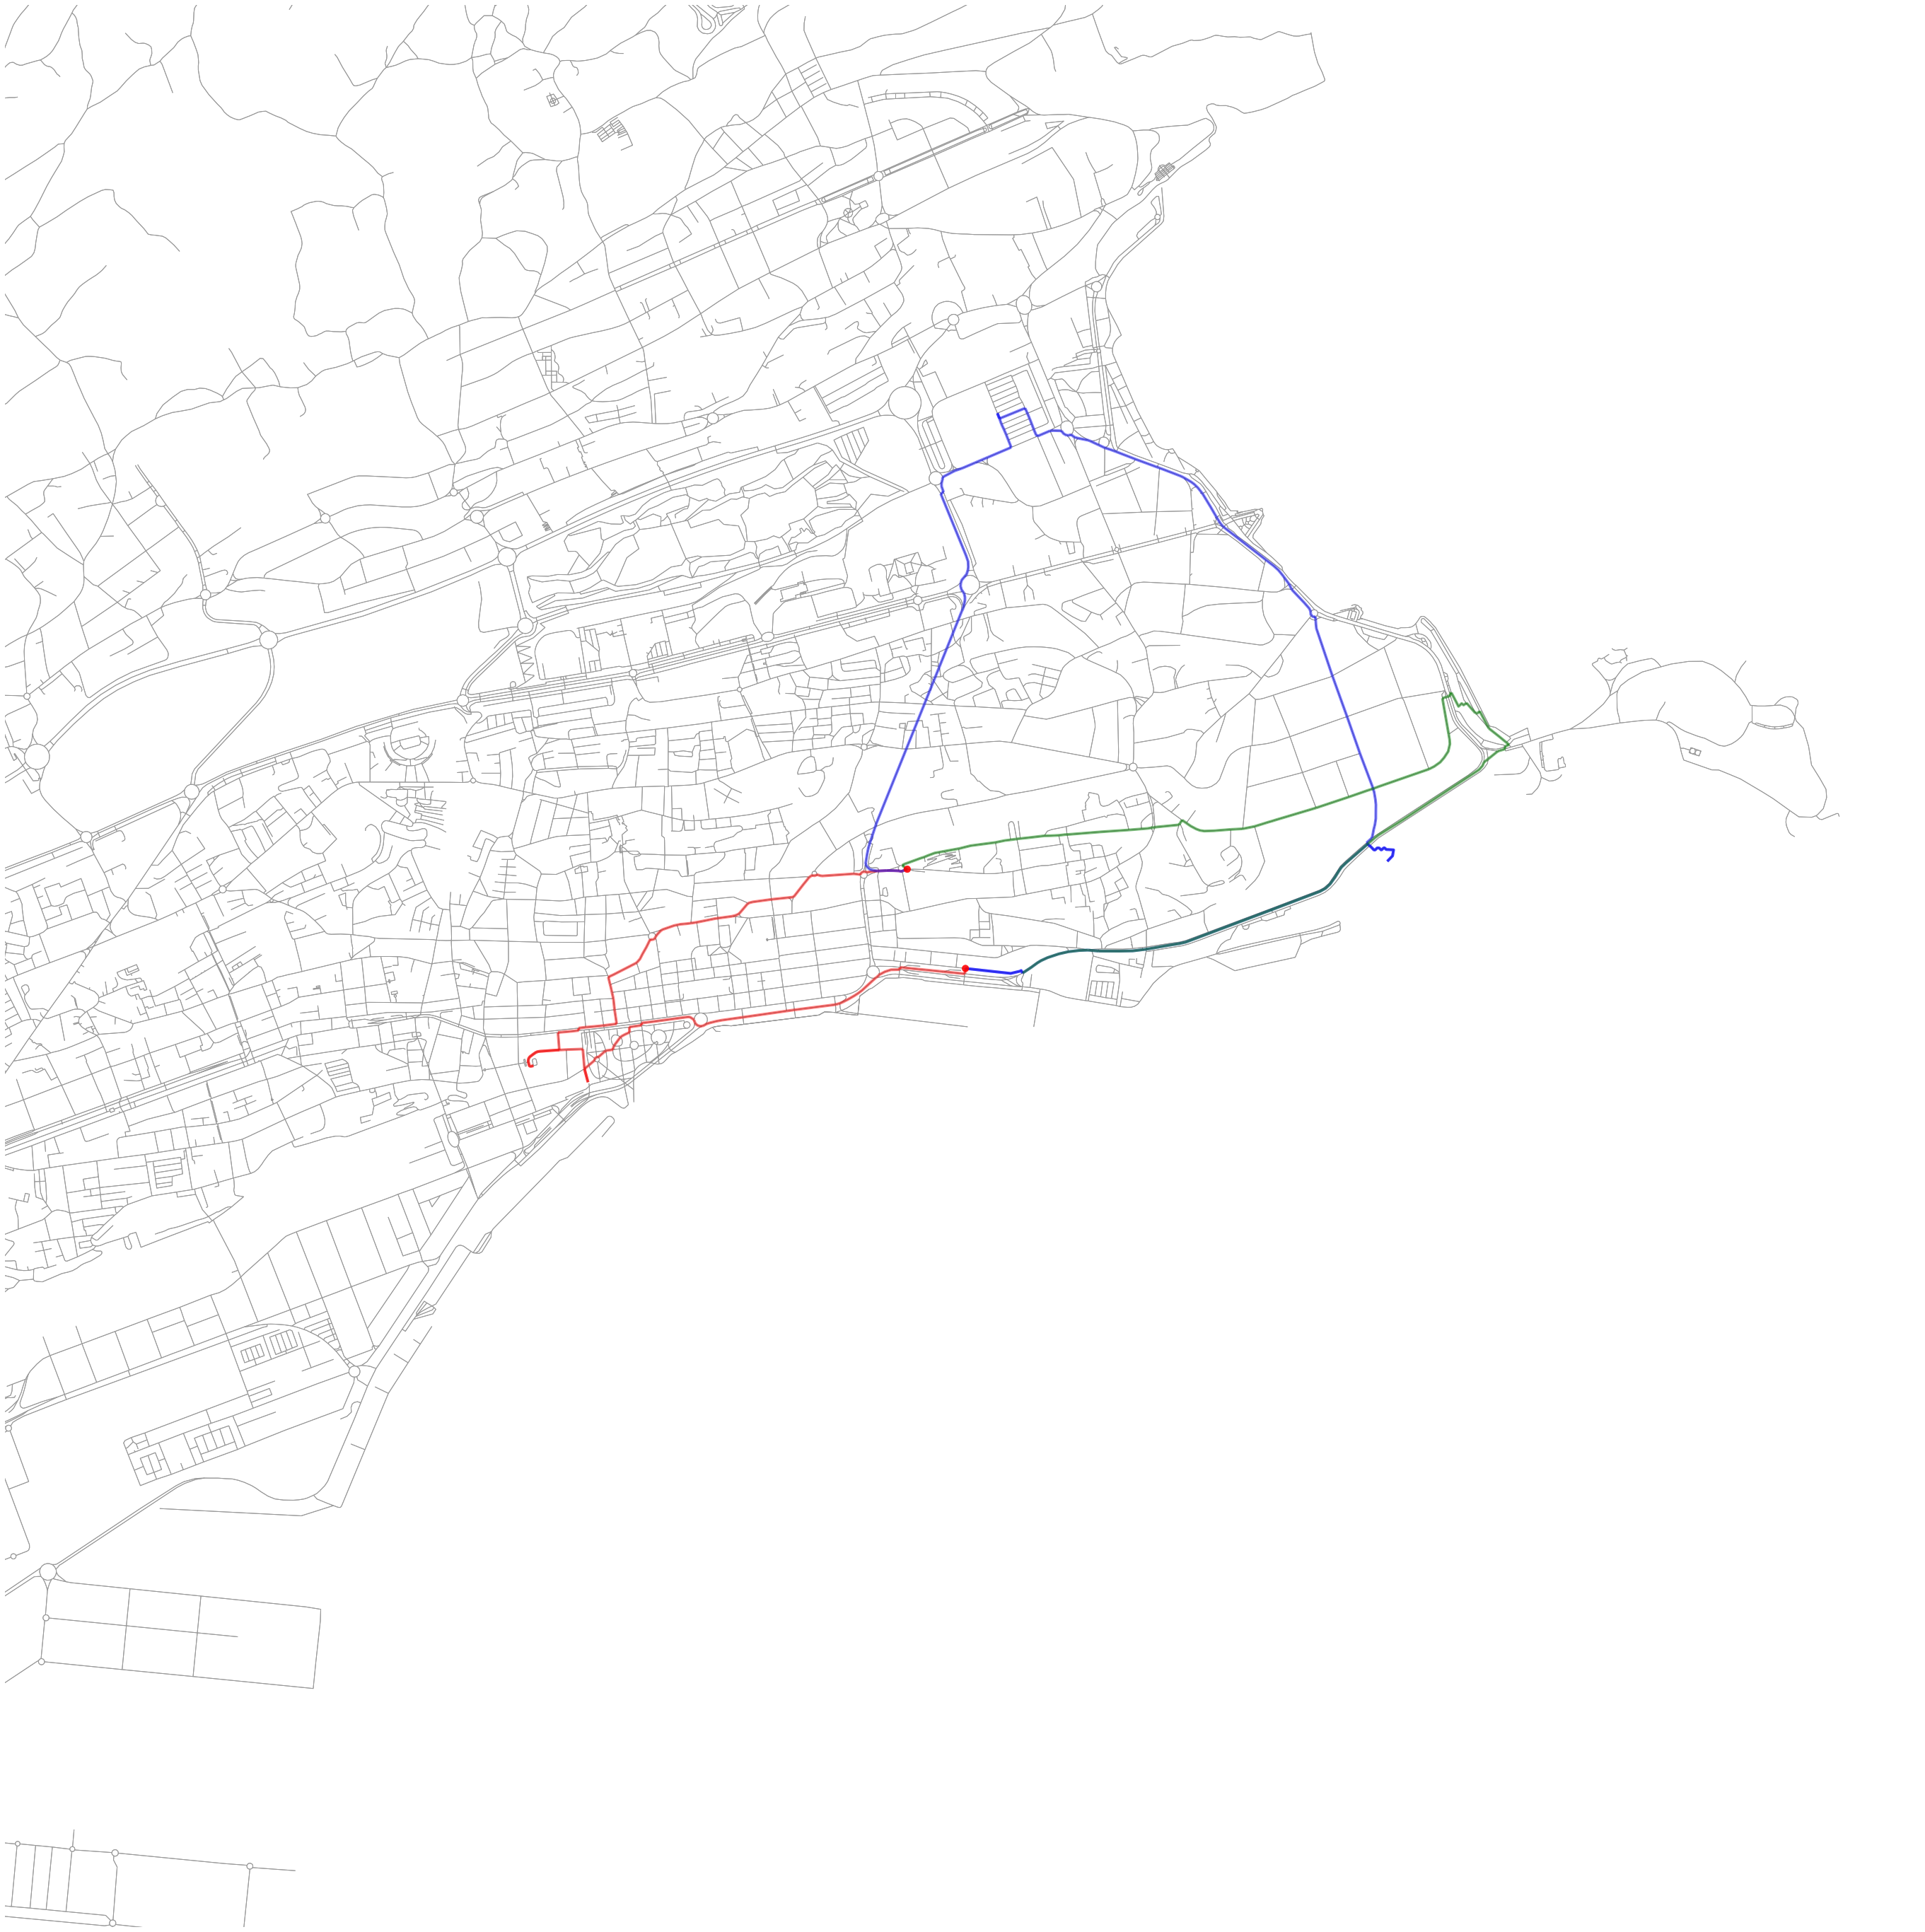

In [52]:
routes = []
for j in range(0,len(best_paths)):
    temp = []
    for i in range(0,len(best_paths[j])-1):
        # get the route from each point to the next one
        orig_node = ox.get_nearest_node(G, data[best_paths[j][i]][:-1])
        dest_node = ox.get_nearest_node(G, data[best_paths[j][i+1]][:-1])
        if i == len(best_paths[j])-2:
            temp += nx.shortest_path(G, orig_node, dest_node, weight='length')
        else:
            temp += nx.shortest_path(G, orig_node, dest_node, weight='length')[0:-1]
    routes.append(temp)

# create route colors
list_colors = ['r', 'b', 'g', 'y', 'p']
rc = []
rc += [list_colors[0]] * (len(routes[0]) - 1)
for i in range(1,len(routes)):
    rc += [list_colors[i]] * len(routes[i])

# plot the routes
fig, ax = ox.plot_graph_routes(G, routes, route_color=rc,  node_size=0, bbox=ox.core.bbox_from_point(data[0][0:-1], distance=Tmax/2), fig_height=50)